In [1]:
import matplotlib
import warnings
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#sklearn 机器学习
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Wordcloud 词云库
from wordcloud import WordCloud

%matplotlib inline
#参数字典：rcParams(run configuration de Params
# matplotlib的配置文件为输出图形几乎所有属性设置了默认值
# 通过参数字典可以修改指定key的配置项
plt.rcParams['font.sans-serif'] = 'SimHei'    # 使图形中的中文正常编码显示
plt.rcParams['axes.unicode_minus'] = False    # 使坐标轴刻度标签正常显示正负号
matplotlib.rcParams.update({'font.size' : 16})# 修改字体大小
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

## 1 项目背景
### 1.1 项目背景与挖掘目标

In [2]:
# 查看会员信息表
df_cum = pd.read_excel('./sourceData/cumcm2018c1.xlsx')
df_cum

,会员卡号,出生日期,性别,登记时间
0,c68b20b4,2002-11-02 00:00:00,0.0,2013-05-11 00:00:00.000
1,1ca15332,NaN,0.0,2004-11-04 16:31:52.436
2,a37cc182,1967-02-17 00:00:00,0.0,2004-12-31 21:24:34.216
3,2ab88539,1982-06-01 00:00:00,0.0,2010-11-19 00:00:00.000
4,b4c77269,1964-02-05 00:00:00,0.0,2007-12-14 00:00:00.000
...,...,...,...,...
194755,a97474e0,NaN,NaN,NaT
194756,4e14ad22,NaN,0.0,2013-08-30 00:00:00.000
194757,f20299a8,NaN,NaN,2014-03-18 00:00:00.000
194758,a3a27f12,1973-01-10 00:00:00,0.0,2015-03-10 00:00:00.000


In [3]:
# 查看销售流水表
df_sale = pd.read_csv('./sourceData/cumcm2018c2.csv', encoding = 'utf8')
df_sale

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,收银机号,单据号,柜组编码,柜组名称
0,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,290.0,270.20,兰芝化妆品正价瓶,270.20,6,25bb,8077.0,兰芝柜
1,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,325.0,302.80,兰芝化妆品正价瓶,302.80,6,25bb,8077.0,兰芝柜
2,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,195.0,181.80,兰芝化妆品正价瓶,181.80,6,25bb,8077.0,兰芝柜
3,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,270.0,251.55,兰芝化妆品正价瓶,251.55,6,25bb,8077.0,兰芝柜
4,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,2,245.0,456.55,兰芝化妆品正价瓶,456.55,6,25bb,8077.0,兰芝柜
...,...,...,...,...,...,...,...,...,...,...,...,...
1893527,607c7cde,2018-01-03 21:38:15.343,c483e08b,1,200.0,200.00,植村秀眉笔4g,200.00,91,3d84,8156.0,Shu Uemura
1893528,220c0564,2018-01-03 21:41:53.140,cd93b1ca,1,1.0,1.00,爱慕内衣正价件,1.00,264,7cd8,4332.0,Aimer
1893529,220c0564,2018-01-03 21:41:53.140,cd93b1ca,1,490.0,490.00,爱慕内衣正价件,490.00,264,7cd8,4332.0,Aimer
1893530,220c0564,2018-01-03 21:41:53.140,cd93b1ca,1,280.0,280.00,爱慕内衣正价件,280.00,264,7cd8,4332.0,Aimer


## 2 数据探索与预处理
### 2.1 结合业务对数据进行探索然后预处理
#### 会员信息表数据探索和预处理

In [4]:
# 对会员数据表分析
# shape[0]获取行数；shape[0]获取列数
print('会员信息表一共有{}行记录，{}列字段'.format(df_cum.shape[0], df_cum.shape[1]))
# mean是求均值的，bool值中的true是1，false是0；计算得到下面的均值
print('数据缺失的情况：\n{}'.format(df_cum.isnull().mean()))
print('会员卡号（不重复）有{}条记录'.format(len(df_cum['会员卡号'].unique()))) # unique去重

会员信息表一共有194760行记录，4列字段
数据缺失的情况：
会员卡号    0.000000
出生日期    0.175539
性别      0.048444
登记时间    0.065126
dtype: float64
会员卡号（不重复）有194754条记录


上面的信息可以简要分析出一下结果：
- 会员卡号有6条重复；
- 出生日期缺失数据较多；
- 性别缺失较少，可以采用众数填充缺失值；

In [5]:
# 去除卡号重复值
# drop_duplicates:返回去除重复值后的DataFrame（数据集
df_cum.drop_duplicates(subset = '会员卡号', inplace = True)
print('会员卡号（去重）有{}条记录'.format(len(df_cum['会员卡号'])))

# 去除登记时间的缺失值
# dropna：removing missing values
df_cum.dropna(subset = ['登记时间'], inplace = True)
print('df_cum(卡号去重和登记时间去缺失）有{}条记录'.format(df_cum.shape[0]))

会员卡号（去重）有194754条记录
df_cum(卡号去重和登记时间去缺失）有182070条记录


In [6]:
# 性别缺失的比列较少，可以采用众数来填充
# df.fillna(x):用x替换所有的空值
# mode()返回众数
# 下面代码即用性别的众数，填充空值
df_cum['性别'].fillna(df_cum['性别'].mode().values[0], inplace = True)
df_cum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182070 entries, 0 to 194759
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   会员卡号    182070 non-null  object        
 1   出生日期    154474 non-null  object        
 2   性别      182070 non-null  float64       
 3   登记时间    182070 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 6.9+ MB


In [7]:
# 检查登记时间是否还存在异常值，如果存在，下面的操作不能正常执行。如果执行成功，则没有异常值
# 下面的代码是对所有的日期加一
df = df_cum['登记时间'] + pd.Timedelta(days = 1)
df

0        2013-05-12 00:00:00.000
1        2004-11-05 16:31:52.436
2        2005-01-01 21:24:34.216
3        2010-11-20 00:00:00.000
4        2007-12-15 00:00:00.000
                   ...          
194754   2013-10-30 00:00:00.000
194756   2013-08-31 00:00:00.000
194757   2014-03-19 00:00:00.000
194758   2015-03-11 00:00:00.000
194759   2010-08-10 00:00:00.000
Name: 登记时间, Length: 182070, dtype: datetime64[ns]

In [8]:
# 查看处理后缺失值情况
df_cum.isnull().mean()

会员卡号    0.000000
出生日期    0.151568
性别      0.000000
登记时间    0.000000
dtype: float64

上面的结果表名，经过处理的字段都去除了缺失值

In [9]:
# 不对出生日期处理的原因是因为，出生日期缺失值太多，如果贸然删除，会影响后面的操作
# 所以下面新建一个数据集来保存 出生日期 和 性别 信息，方便下面对这两个字段进行统计
# 下面代码的意思是，选取出生日期字段 不为空的数据，然后取出这条数据里面的出生日期和性别
# 建立新的数据集
L = pd.DataFrame(df_cum.loc[df_cum['出生日期'].notnull(),['出生日期','性别']])
# astype(str):将出生日期这一列转换成字符串
# 然后使用lambada进行处理,转换成字符串后，[:4]取出的元素就是出生年份，切片是左闭右开，所以到4
##### 下面的[0:3]实际只取到了年份的前三位数，后面加一个0构造完整年份，
##### 如果直接取完整年份，后面的图会非常的拥挤
L['年龄'] = L['出生日期'].astype(str).apply(lambda x: x[:3] + '0')
# drop：axis = 1，对列操作；出生日期：将这列移除
L.drop('出生日期', axis = 1, inplace = True)
# value_counts()：统计字段中每个年龄有多少人
L['年龄'].value_counts()

1980    47142
1970    43407
1960    26678
1750    16748
1990    11811
1950     7078
1940      893
2010      370
2000      139
1930      110
1920       32
1900       21
1910        8
1880        4
1890        3
1860        3
5220        2
1870        2
1760        2
1850        2
9790        1
1790        1
2640        1
1780        1
8500        1
8900        1
7710        1
5190        1
9740        1
1770        1
5010        1
2190        1
9820        1
9880        1
1820        1
8400        1
8700        1
9690        1
6200        1
Name: 年龄, dtype: int64

In [10]:
# 剔除出生日期中的异常值1920年至今的范围为合理的
L['年龄'] = L['年龄'].astype(int)
condition = "年龄 >= 1920 and 年龄 <= 2020"
L = L.query(condition)
L.index = range(L.shape[0])
L['年龄'].value_counts()

1980    47142
1970    43407
1960    26678
1990    11811
1950     7078
1940      893
2010      370
2000      139
1930      110
1920       32
Name: 年龄, dtype: int64

In [11]:
# 与销售流水表进行合并的数据只取 会员卡号，性别，登记时间
df_cum.drop('出生日期', axis = 1, inplace = True)
df_cum.index = range(df_cum.shape[0])
print('数据清洗之后共有{}条记录，{}列字段，字段分别为{}'.format(df_cum.shape[0],df_cum.shape[1], df_cum.columns.tolist()))

数据清洗之后共有182070条记录，3列字段，字段分别为['会员卡号', '性别', '登记时间']


In [12]:
df_cum

,会员卡号,性别,登记时间
0,c68b20b4,0.0,2013-05-11 00:00:00.000
1,1ca15332,0.0,2004-11-04 16:31:52.436
2,a37cc182,0.0,2004-12-31 21:24:34.216
3,2ab88539,0.0,2010-11-19 00:00:00.000
4,b4c77269,0.0,2007-12-14 00:00:00.000
...,...,...,...
182065,716746bc,0.0,2013-10-29 00:00:00.000
182066,4e14ad22,0.0,2013-08-30 00:00:00.000
182067,f20299a8,0.0,2014-03-18 00:00:00.000
182068,a3a27f12,0.0,2015-03-10 00:00:00.000


#### 销售流水表数据探索和预处理

In [13]:
df_sale.columns

Index(['会员卡号', '消费产生的时间', '商品编码', '销售数量', '商品售价', '消费金额', '商品名称', '此次消费的会员积分',
       '收银机号', '单据号', '柜组编码', '柜组名称'],
      dtype='object')

In [14]:
df_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1893532 entries, 0 to 1893531
Data columns (total 12 columns):
 #   Column     Dtype  
---  ------     -----  
 0   会员卡号       object 
 1   消费产生的时间    object 
 2   商品编码       object 
 3   销售数量       int64  
 4   商品售价       float64
 5   消费金额       float64
 6   商品名称       object 
 7   此次消费的会员积分  float64
 8   收银机号       int64  
 9   单据号        object 
 10  柜组编码       float64
 11  柜组名称       object 
dtypes: float64(4), int64(2), object(6)
memory usage: 173.4+ MB


In [15]:
# 销售数量全部大于0
print('销售数量大于0的记录有：{}\t 全部记录有：{} \t 两者是否相等：{}'.format(len(df_sale['销售数量']>0),df_sale.shape[0], len(df_sale['销售数量']>0) == df_sale.shape[0]))
print('销售金额大于0的记录有：{}\t 全部记录有：{} \t 两者是否相等：{}'.format(len(df_sale['消费金额']>0),df_sale.shape[0], len(df_sale['消费金额']>0) == df_sale.shape[0]))

销售数量大于0的记录有：1893532	 全部记录有：1893532 	 两者是否相等：True
销售金额大于0的记录有：1893532	 全部记录有：1893532 	 两者是否相等：True


In [16]:
df_sale.isnull().mean()

会员卡号         0.537348
消费产生的时间      0.000000
商品编码         0.000000
销售数量         0.000000
商品售价         0.000000
消费金额         0.000000
商品名称         0.000000
此次消费的会员积分    0.537348
收银机号         0.000000
单据号          0.000000
柜组编码         0.537348
柜组名称         0.547631
dtype: float64

会员卡号、此次消费的会员积分、柜组编码、柜组名称存在缺失

In [17]:
# 会员信息表和销售流水表 连接这两张表的字段是会员卡号
# 销售流水表中会员卡号的缺失值太大，一半多缺失。
# 不能填充，且会影响后面的统计分析和建模，所以只能舍弃
# dropna:去除所有空字段
df_sale_clearn = df_sale.dropna(subset = ['会员卡号'])
df_sale_clearn.isnull().mean()

会员卡号         0.000000
消费产生的时间      0.000000
商品编码         0.000000
销售数量         0.000000
商品售价         0.000000
消费金额         0.000000
商品名称         0.000000
此次消费的会员积分    0.000000
收银机号         0.000000
单据号          0.000000
柜组编码         0.000000
柜组名称         0.022225
dtype: float64

去除掉会员卡号缺失值后，就只有柜组名称还存在一小部分缺失。
继续清洗掉无意义的字段，仅保留有研究价值的信息

In [18]:
df_sale_clearn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876046 entries, 0 to 1893531
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   会员卡号       876046 non-null  object 
 1   消费产生的时间    876046 non-null  object 
 2   商品编码       876046 non-null  object 
 3   销售数量       876046 non-null  int64  
 4   商品售价       876046 non-null  float64
 5   消费金额       876046 non-null  float64
 6   商品名称       876046 non-null  object 
 7   此次消费的会员积分  876046 non-null  float64
 8   收银机号       876046 non-null  int64  
 9   单据号        876046 non-null  object 
 10  柜组编码       876046 non-null  float64
 11  柜组名称       856576 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 86.9+ MB


In [19]:
df_sale_clearn.drop(['收银机号','柜组编码', '柜组名称'], axis = 1, inplace = True)
df_sale_clearn.index = range(df_sale_clearn.shape[0])

In [20]:
type(df_sale_clearn) ==type(df_cum)

True

### 2.2 将会员信息表和销售流水表关联合并

In [21]:
# 重新查看一下各个数据集的长度
print(f'会员信息表中的记录为{len(df_cum)}\t销售流水表中的记录为{len(df_sale_clearn)}')

会员信息表中的记录为182070	销售流水表中的记录为876046


In [22]:
# 按照会员卡号将两张表合并，左连接合并，获得一张宽表
df = pd.merge(df_sale_clearn, df_cum, on = '会员卡号', how = 'left')
df

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,单据号,性别,登记时间
0,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,290.0,270.20,兰芝化妆品正价瓶,270.20,25bb,NaN,NaT
1,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,325.0,302.80,兰芝化妆品正价瓶,302.80,25bb,NaN,NaT
2,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,195.0,181.80,兰芝化妆品正价瓶,181.80,25bb,NaN,NaT
3,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,270.0,251.55,兰芝化妆品正价瓶,251.55,25bb,NaN,NaT
4,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,2,245.0,456.55,兰芝化妆品正价瓶,456.55,25bb,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...
876041,607c7cde,2018-01-03 21:38:15.343,c483e08b,1,200.0,200.00,植村秀眉笔4g,200.00,3d84,0.0,2017-09-02 19:44:50.123
876042,220c0564,2018-01-03 21:41:53.140,cd93b1ca,1,1.0,1.00,爱慕内衣正价件,1.00,7cd8,NaN,NaT
876043,220c0564,2018-01-03 21:41:53.140,cd93b1ca,1,490.0,490.00,爱慕内衣正价件,490.00,7cd8,NaN,NaT
876044,220c0564,2018-01-03 21:41:53.140,cd93b1ca,1,280.0,280.00,爱慕内衣正价件,280.00,7cd8,NaN,NaT


In [23]:
filt1 = df['消费金额'] > 0
filt2 = df['此次消费的会员积分'] > 0
filt3 = df['销售数量'] > 0
df1 = df.loc[filt1 & filt2 & filt3, :]
df1.index = range(df1.shape[0])
df1.shape

(738462, 11)

两张表合并后异常值变多，需要进行预处理，筛选掉异常值，以便后面分析

In [24]:
# 创造一个特征字段，判断是否为会员，1表示会员，0表示非会员
df1['会员'] = 1
df1.loc[df1['性别'].isnull(), '会员'] = 0
df1.head()

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,单据号,性别,登记时间,会员
0,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,290.0,270.20,兰芝化妆品正价瓶,270.20,25bb,NaN,NaT,0
1,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,325.0,302.80,兰芝化妆品正价瓶,302.80,25bb,NaN,NaT,0
2,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,195.0,181.80,兰芝化妆品正价瓶,181.80,25bb,NaN,NaT,0
3,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,270.0,251.55,兰芝化妆品正价瓶,251.55,25bb,NaN,NaT,0
4,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,2,245.0,456.55,兰芝化妆品正价瓶,456.55,25bb,NaN,NaT,0


## 3 统计分析
### 3.1 分析会员的年龄构成，男女比列等基本信息

In [25]:
# 分析男女比列，男：1，女：0
L.info

<bound method DataFrame.info of          性别    年龄
0       0.0  2000
1       0.0  1960
2       0.0  1980
3       0.0  1960
4       1.0  1960
...     ...   ...
137655  1.0  1990
137656  1.0  1970
137657  1.0  1980
137658  0.0  1970
137659  0.0  1960

[137660 rows x 2 columns]>

In [26]:
L['性别'] = L['性别'].apply(lambda x: '男' if x == 1.0 else '女')

In [27]:
sex_sort = L['性别'].value_counts()
sex_sort

女    108283
男     29377
Name: 性别, dtype: int64

In [28]:
# 将年龄划分成三个阶段：老年：1920-1950，中年：1950-1990，青年：1990-2010
# 然后绘制饼图

# 中年人数最多，初始值设置为中年，然后条件判断设置青年和老年
L['年龄段'] = '中年'
L.loc[L['年龄'] <= 1950, '年龄段'] = '老年'
L.loc[L['年龄'] >= 1990, '年龄段'] = '青年'
res = L['年龄段'].value_counts()
res

中年    117227
青年     12320
老年      8113
Name: 年龄段, dtype: int64

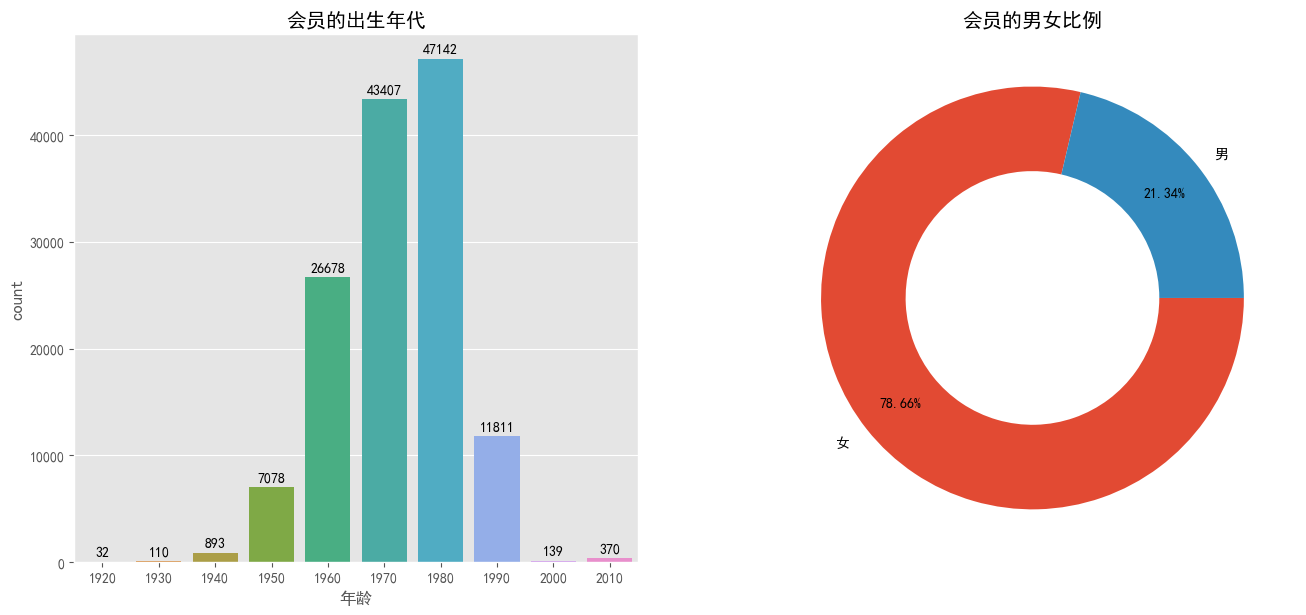

In [29]:
# 使用上面预处理数据集L画图，包含两个字段，分别是 年龄 和 性别

# fig：figure缩写，作用：创建画布；axs：axis，坐标轴
# 第一个参数 ‘1’：子图的行数为一，‘2’：子图的列数为二
# figsize：画布尺寸；dpi：像素密度，默认100
# subplot：会在一幅图中生成多个子图
fig, axs = plt.subplots(1, 2, figsize = (16, 7), dpi = 100)

# 绘制年龄的柱状图
# sns：seaborn库
ax = sns.countplot(x = '年龄', data = L, ax = axs[0])

# 设置数字标签
for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x() + (p.get_width() / 2), y = height + 500, s = '{:.0f}'.format(height), ha = 'center')
axs[0].set_title('会员的出生年代')

# 绘制饼图
axs[1].pie(sex_sort, labels = sex_sort.index, wedgeprops = {'width': 0.4}, counterclock = False, autopct = '%.2f%%', pctdistance = 0.8)
axs[1].set_title('会员的男女比例')
plt.savefig('./images/会员出生年代及男女比例情况.png')

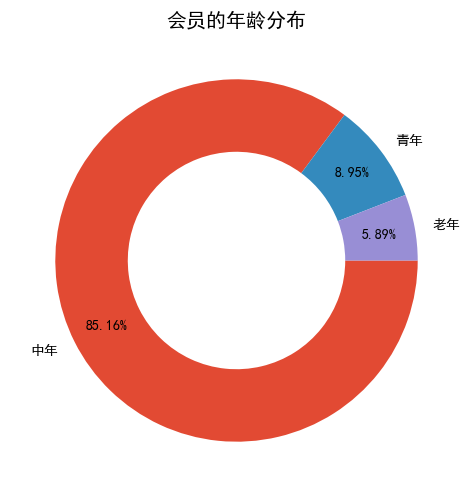

In [30]:
# 绘制各个年龄段的饼图
plt.figure(figsize = (8,6), dpi = 100)
plt.pie(res.values, labels = ['中年', '青年', '老年'], autopct = '%.2f%%', pctdistance = 0.8,
        counterclock = False, wedgeprops = {'width':0.4})
plt.title('会员的年龄分布')
plt.savefig('./images/会员的年龄分布.png')

### 3.2 分析会员的总订单占比，总消费金额占比等消费情况

Text(0.5, 1.0, '消费金额占比')

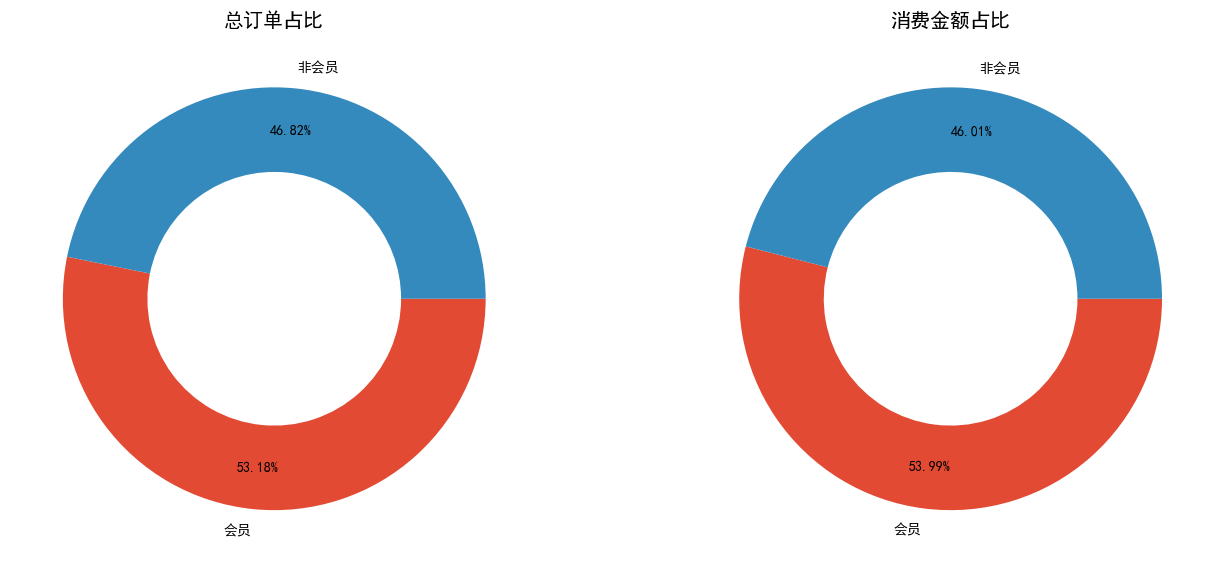

In [31]:
# 1：会员；0：非会员
# 在这个数据集里面，相同的订单号可能不是同一笔消费，所以使用消费时的时间来区分是否是同一笔消费
# 同一个时间的为同一笔消费

fig, axs = plt.subplots(1, 2, figsize=(16, 7), dpi=100)  # 一个画布，两个子图
# 订单占比饼图
axs[0].pie([len(df1.loc[df1['会员'] == 1,'消费产生的时间'].unique()), len(df1.loc[df1['会员'] == 0, '消费产生的时间'].unique())],
          labels = ['会员', '非会员'], wedgeprops = {'width':0.4}, counterclock = False, autopct = '%.2f%%', pctdistance = 0.8)
axs[0].set_title('总订单占比')
# 消费金额占比图
axs[1].pie([sum(df1.loc[df1['会员'] == 1, '消费金额']), sum(df1.loc[df1['会员'] == 0, '消费金额'])],
           labels = ['会员', '非会员'], wedgeprops = {'width':0.4}, counterclock = False, autopct = '%.2f%%', pctdistance = 0.8)
axs[1].set_title('消费金额占比')

### 3.3 分别以季度和天为单位，分析不同时间段会员的消费时间偏好
> 去统计每个季度的订单数量，和每天的订单数量
因为数据是2015-2018的，所以对于季度采用平均值，需要除以3
对于天数则除以36，因为每个月的每一天在三年的时间里面会出现36次（极个别日期除外

In [32]:
# 去除空值
df_vip = df1.dropna()
# axis = 1：表示对列进行处理；inplace = true：表示返回空值
# 下面的意思是删除 会员 列，并返回空值
df_vip.drop(['会员'], axis = 1, inplace = True)
# 给df_vip创建索引，默认会从0，n-1创建
df_vip.index = range(df_vip.shape[0])
df_vip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393482 entries, 0 to 393481
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   会员卡号       393482 non-null  object        
 1   消费产生的时间    393482 non-null  object        
 2   商品编码       393482 non-null  object        
 3   销售数量       393482 non-null  int64         
 4   商品售价       393482 non-null  float64       
 5   消费金额       393482 non-null  float64       
 6   商品名称       393482 non-null  object        
 7   此次消费的会员积分  393482 non-null  float64       
 8   单据号        393482 non-null  object        
 9   性别         393482 non-null  float64       
 10  登记时间       393482 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(5)
memory usage: 33.0+ MB


In [33]:
type(df_vip['消费产生的时间'][1])
# 将 消费产生的时间 这一列的数据类型从str 转换成datetime
df_vip['消费产生的时间'] = pd.to_datetime(df_vip['消费产生的时间'])
# 从消费产生的时间里面提取出，年 季 月 日 信息
df_vip['年'] = df_vip['消费产生的时间'].dt.year
df_vip['季'] = df_vip['消费产生的时间'].dt.quarter
df_vip['月'] = df_vip['消费产生的时间'].dt.month
df_vip['日'] = df_vip['消费产生的时间'].dt.day
df_vip.head()

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,单据号,性别,登记时间,年,季,月,日
0,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1760.0,1760.0,MARYLINGC件,1678.82,5858,0.0,2007-08-12,2015,1,1,1
1,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,9072.0,9072.0,MARYLINGC件,8653.56,5858,0.0,2007-08-12,2015,1,1,1
2,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,1507.0,1507.0,汤普葛罗女鞋活动促销双,1437.49,5858,0.0,2007-08-12,2015,1,1,1
3,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,899.0,899.0,汤普葛罗女鞋活动促销双,857.54,5858,0.0,2007-08-12,2015,1,1,1
4,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1960.0,1960.0,MARYLINGC件,1869.59,5858,0.0,2007-08-12,2015,1,1,1


In [34]:
# 定义一个函数用来计算订单平均数
def orders(df, label, div):
    '''
    df:数据集
    label:列标签
    div:除数
    '''
    # 去重获取列中不同的种类，然后转换成列表排序
    x_list = np.sort(df[label].unique().tolist())
    order_nums = []
    for i in range(len(x_list)):
        order_nums.append(int(len(df.loc[df[label] == x_list[i], '消费产生的时间'].unique()) / div))
    return x_list, order_nums

季度的均值消费偏好消费的最优为：2	 对应的消费情况为：19886
天数的均值消费偏好消费的最优为：26	 对应的消费情况为：350


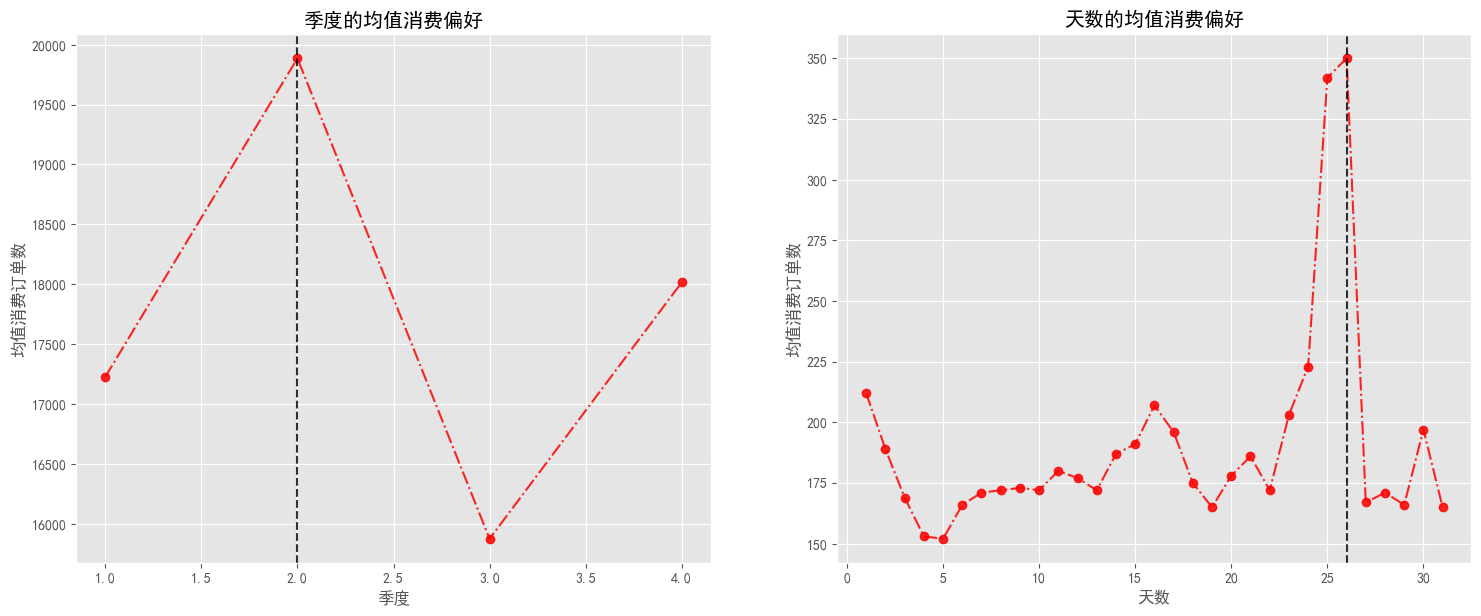

In [35]:
quarters_list, quarters_order = orders(df_vip, '季', 3)
days_list, days_order = orders(df_vip, '日', 36)
time_list = [quarters_list, days_list]
order_list = [quarters_order, days_order]
# 最大值索引位置列表
maxindex_list = [quarters_order.index(max(quarters_order)), days_order.index(max(days_order))]

fig, axs = plt.subplots(1, 2, figsize = (18, 7), dpi = 100)
titles = ['季度的均值消费偏好', '天数的均值消费偏好']
labels = ['季度', '天数']
for i in range(len(axs)):
    ax = axs[i]
    ax.plot(time_list[i], order_list[i], linestyle = '-.', c = 'r', marker = 'o', alpha = 0.85)
    # 添加一个垂直与x的轴
    ax.axvline(x = time_list[i][maxindex_list[i]], linestyle = '--', c = 'k', alpha = 0.8)
    ax.set_title(titles[i])
    ax.set_xlabel(labels[i])
    ax.set_ylabel('均值消费订单数')
    print(f'{titles[i]}消费的最优为：{time_list[i][maxindex_list[i]]}\t 对应的消费情况为：{order_list[i][maxindex_list[i]]}')
plt.savefig('./images/季度和天数的均值消费情况.png')

In [36]:
# 定义一个函数用来绘制每个年份的季度和天数的趋势图
def plot_qd(df, label_list, nrow=1, ncol=1):
    """
    df:传入的DataFrame数据集
    label_list:标签列表
    nrow：图的行数，默认1
    rcol：图的列数，默认1
    """
    # 得到数据集中的年份数据，有几个年份,2018年的数据不完整，所有去掉2018
    year_list = np.sort(df['年'].unique().tolist())[:-1]
    # 从给定的样本中随机选择 有几个线条就返回几个线条颜色
    colors = np.random.choice(['r', 'g', 'b', 'orange', 'y', 'k', 'c', 'm'], replace = False, size = len(year_list))
    markers = ['o', '^', 'v', '+']
    
    
    # 判断需要绘制的图像有几个，然后创建子图
    if len(label_list) == 1:
        fig, axs = plt.subplots(figsize = (16, 7), dpi = 100)
    else:
        fig, axs = plt.subplots(nrow, ncol, figsize = (16, 7), dpi = 100)
    
    for i in range(len(label_list)):
        # 指标种类列表 存放每一个指标下不同指标数量
        # 转换成列表然后排序
        index_list = np.sort(df[label_list[i]].unique().tolist())
        # 这个循环对year_list循环，用来绘制列表大小的线条
        for j in range(len(year_list)):
            order_nums = []
            # 这里判断出列中数据 是否是当前循环的年
            condition1 = (df['年'] == year_list[j])
            for k in range(len(index_list)):
                # 判断列中数据是否是同一季度或同一天
                condition2 = (df[label_list[i]] == index_list[k])
                # 两个条件都满足  则这条记录是同一年的同一季度或同一天的
                order_nums.append(len(df.loc[condition1 & condition2, '消费产生的时间'].unique()))
            axs[i].plot(index_list, order_nums, linestyle ='-.', c = colors[j], alpha = 0.8, marker = markers[j], label = year_list[j], markersize = 4)
        axs[i].set_xlabel(f'{label_list[i]}')
        axs[i].set_ylabel('消费订单数')
        axs[i].set_title(f'{min(year_list)}-{max(year_list)}年会员的{label_list[i]}消费订单差异')
        # 使图例生效   在axs.plot中设置的label生效
        axs[i].legend()
    plt.savefig(f'./images/{min(year_list)}-{max(year_list)}年会员的消费订单差异.png')
            

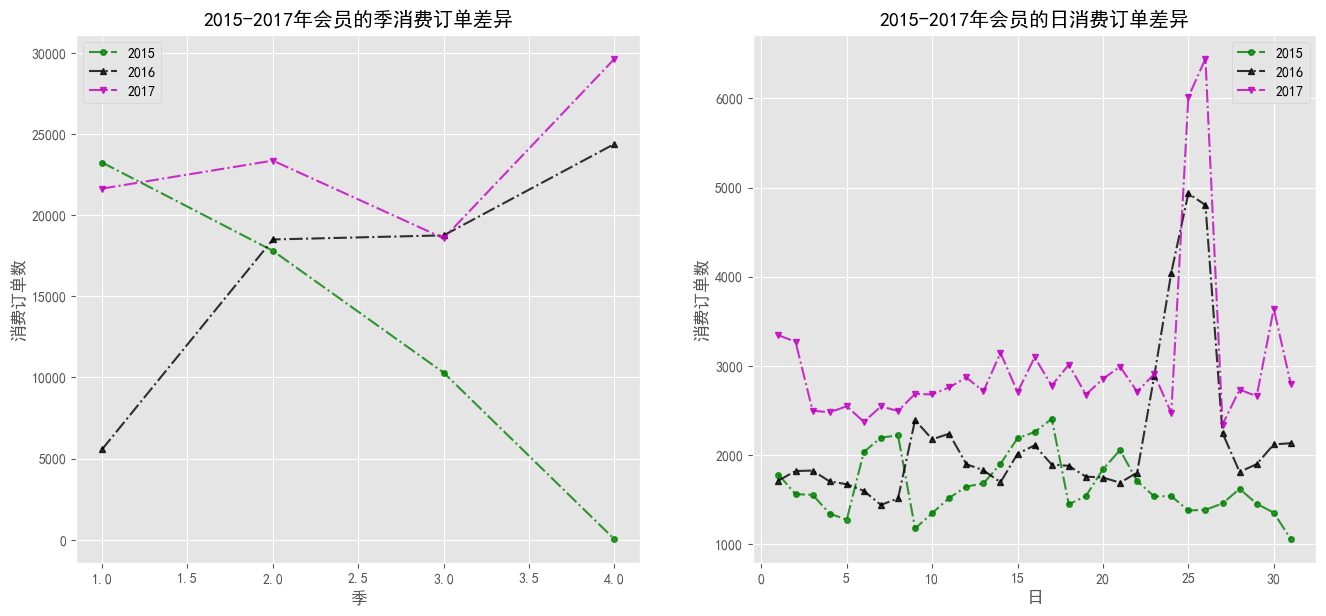

In [37]:
plot_qd(df_vip, ['季', '日'], 1, 2)

In [38]:
# 创建一个简单的绘图函数
def plot_png(xdata, ydata, xname, yname, titlename, color, mark, labelname, ax):
    """
    xdata:x轴数据集
    ydata:y轴数据集
    xname:x轴名称
    yname:y轴名称
    titlename:图标题
    color
    mark
    labelname:图例名称
    ax:plt对象
    """
    ax.plot(xdata, ydata, linestyle = '-.', c = color, alpha = 0.8, marker = mark, label = labelname, markersize = 4)
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.set_title(titlename)
    ax.legend()

In [39]:
# 自定义函数来绘制不同年份之间 每个月的消费差异（消费订单总数和消费金额的图像
def plot_ym(df):
    """
    df:dataframe 数据集
    """
    year_list = np.sort(df['年'].unique().tolist())[:-1]
    month_list = np.sort(df['月'].unique().tolist())
    colors = np.random.choice(['r', 'g', 'b', 'orange', 'y', 'k', 'c', 'm'], replace = False, size = len(year_list))
    markers = ['o', '^', 'v', '+']
    fig, axs = plt.subplots(1, 2, figsize = (16, 7), dpi = 100)
    for i in range(len(year_list)):
        # 每月订单总量
        order_nums = []
        # 每月消费金额
        money_nums = []
        # 循环月份，填充两个数组
        for j in range(len(month_list)):
            condition = (df['年'] == year_list[i]) & (df['月'] == month_list[j])
            order_nums.append(len(df.loc[condition, '消费产生的时间'].unique()))
            money_nums.append(df.loc[condition, '消费金额'].sum())
        plot_png(month_list, order_nums, '月', '订单数', '2015-2017年订单数', colors[i], markers[i], year_list[i], axs[0])
        plot_png(month_list, money_nums, '月', '消费金额数', '2015-2017年消费金额数', colors[i], markers[i], year_list[i], axs[1])
    plt.savefig('./images/2015-2017消费订单和消费金额.png')

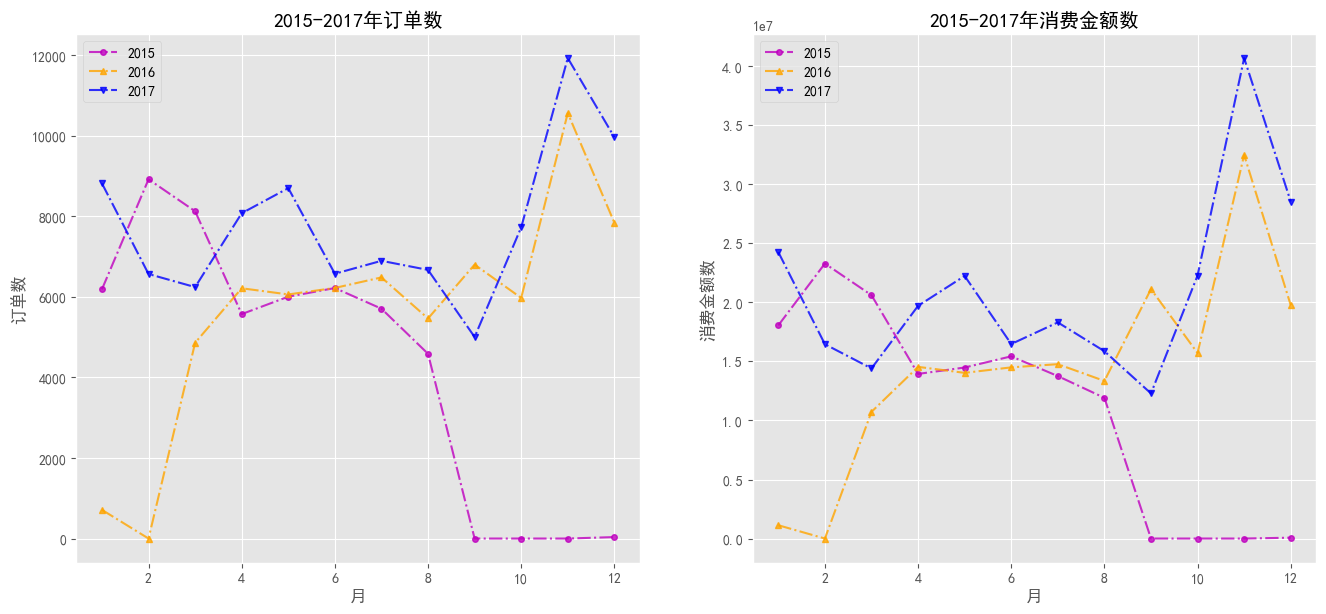

In [40]:
plot_ym(df_vip)

In [41]:
# 再来分析下时间上的差差异——消费订单数
df_vip['时间'] = df_vip['消费产生的时间'].dt.hour
x_list, order_nums = orders(df_vip, '时间', 1)

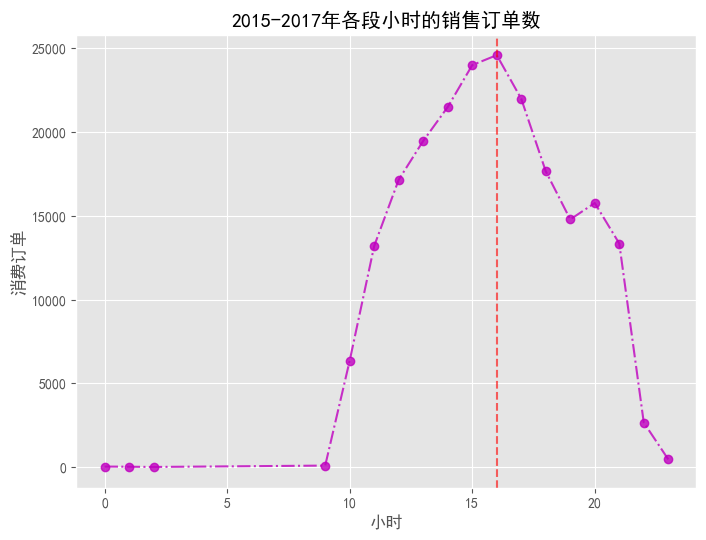

In [42]:
maxindex = order_nums.index(max(order_nums))
plt.figure(figsize = (8, 6), dpi = 100)
plt.plot(x_list, order_nums, linestyle = '-.', marker = 'o', c = 'm', alpha = 0.8)
plt.xlabel('小时')
plt.ylabel('消费订单')
plt.axvline(x = x_list[maxindex], linestyle = '--', c = 'r', alpha = 0.6)
plt.title('2015-2017年各段小时的销售订单数')
plt.savefig('./images/2015-2017年各段小时的销售订单数.png')

In [43]:
# 保存数据
df_vip.to_csv('./saveData/vip_info.csv', encoding = 'gb18030', index = None)

## 4 会员用户画像和特征字段创造
### 4.1 构建会员用户基本标签

In [44]:
# 导入上面保存的文件
df_vip = pd.read_csv('./saveData/vip_info.csv',encoding = 'gbk')
df_vip

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,单据号,性别,登记时间,年,季,月,日,时间
0,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1760.0,1760.0,MARYLINGC件,1678.82,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0
1,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,9072.0,9072.0,MARYLINGC件,8653.56,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0
2,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,1507.0,1507.0,汤普葛罗女鞋活动促销双,1437.49,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0
3,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,899.0,899.0,汤普葛罗女鞋活动促销双,857.54,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0
4,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1960.0,1960.0,MARYLINGC件,1869.59,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393477,826ea280,2018-01-03 21:25:16.236,2c276195,1,299.0,299.0,芭芭麻麻正价件,299.00,fcd0,0.0,2017-12-25 19:30:50.746,2018,1,1,3,21
393478,826ea280,2018-01-03 21:25:16.236,2c276195,1,399.0,399.0,芭芭麻麻正价件,399.00,fcd0,0.0,2017-12-25 19:30:50.746,2018,1,1,3,21
393479,5d761c48,2018-01-03 21:27:28.686,a1e1cc27,1,990.0,990.0,Gucci品牌 正价无,990.00,1f26,0.0,2016-11-25 15:09:06.323,2018,1,1,3,21
393480,607c7cde,2018-01-03 21:38:15.343,3bc576f1,2,480.0,960.0,植村秀腮红刷20,960.00,3d84,0.0,2017-09-02 19:44:50.123,2018,1,1,3,21


In [45]:
# 判断消费金额和积分有没有异常值
# 定义一个函数来判断数值类型的列有没有异常值
def judge_err(df, judge_column):
    """
    df:传入的数据集
    judge_column:需要判断的列
    """
    # 判断列中是否有数据小于0， 有则bool_v的值为true
    bool_v = True in (df[judge_column] < 0).tolist()
    if bool_v:
        print(f'{judge_column} 列: 数据异常')
    else:
        print(f'{judge_column} 列: 数据无异常')

In [46]:
judge_err(df_vip, '此次消费的会员积分')
judge_err(df_vip, '消费金额')

此次消费的会员积分 列: 数据无异常
消费金额 列: 数据无异常


In [47]:
df_vip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393482 entries, 0 to 393481
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   会员卡号       393482 non-null  object 
 1   消费产生的时间    393482 non-null  object 
 2   商品编码       393482 non-null  object 
 3   销售数量       393482 non-null  int64  
 4   商品售价       393482 non-null  float64
 5   消费金额       393482 non-null  float64
 6   商品名称       393482 non-null  object 
 7   此次消费的会员积分  393482 non-null  float64
 8   单据号        393482 non-null  object 
 9   性别         393482 non-null  float64
 10  登记时间       393482 non-null  object 
 11  年          393482 non-null  int64  
 12  季          393482 non-null  int64  
 13  月          393482 non-null  int64  
 14  日          393482 non-null  int64  
 15  时间         393482 non-null  int64  
dtypes: float64(4), int64(6), object(6)
memory usage: 48.0+ MB


In [48]:
# 数据集中最近的一笔消费记录时间为2018-01-03
# 以这个时间来判断是否存在异常值， 即大于这个时间的为异常值
# 判断登记时间和消费时间
consume_time = len(df_vip[df_vip['消费产生的时间']>'2018-01-03'])
checkin_time = len(df_vip[df_vip['登记时间']>'2018-01-03'])
print('消费时间 列的异常值为：', consume_time, '； 登记时间 列的异常值为：', checkin_time)

消费时间 列的异常值为： 469 ； 登记时间 列的异常值为： 36


In [49]:
filter1 = df_vip['消费产生的时间'] < '2018-01-03'
filter2 = df_vip['登记时间'] < '2018-01-03'
df_vip = df_vip[filter1 & filter2]
df_vip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393006 entries, 0 to 393012
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   会员卡号       393006 non-null  object 
 1   消费产生的时间    393006 non-null  object 
 2   商品编码       393006 non-null  object 
 3   销售数量       393006 non-null  int64  
 4   商品售价       393006 non-null  float64
 5   消费金额       393006 non-null  float64
 6   商品名称       393006 non-null  object 
 7   此次消费的会员积分  393006 non-null  float64
 8   单据号        393006 non-null  object 
 9   性别         393006 non-null  float64
 10  登记时间       393006 non-null  object 
 11  年          393006 non-null  int64  
 12  季          393006 non-null  int64  
 13  月          393006 non-null  int64  
 14  日          393006 non-null  int64  
 15  时间         393006 non-null  int64  
dtypes: float64(4), int64(6), object(6)
memory usage: 51.0+ MB


In [50]:
# 会员数量
vip_nums = len(df_vip['会员卡号'].unique())
data_nums = df_vip.shape[0]
print(f'会员数量：{vip_nums}\t数据量：{data_nums}')

会员数量：42548	数据量：393006


In [51]:
df_vip.columns

Index(['会员卡号', '消费产生的时间', '商品编码', '销售数量', '商品售价', '消费金额', '商品名称', '此次消费的会员积分',
       '单据号', '性别', '登记时间', '年', '季', '月', '日', '时间'],
      dtype='object')

筛选每位会员，分析各个字段，求出LRFMP模型

[LRFMP案例](https://www.emerald.com/insight/content/doi/10.1108/MIP-11-2016-0210/full/html)
>The purpose of this paper is to propose a new RFM model called length, recency, frequency, monetary and periodicity (LRFMP) for classifying customers in the grocery retail industry; and to identify different customer segments in this industry based on the proposed model.

L:Length  
R:Recency  
F:Frequency  
M:Moneytary  
P:Points

In [52]:
# 定义一个函数用来计算两个时间的差值
def subtract_time(df, end_time):
    """
    df:dataframe 数据集
    end_time:相减的时间
    """
    df.columns = ['A', 'B']
    df['C'] = end_time
    
    sub_result = pd.to_datetime(df['C']) - pd.to_datetime(df['B'])
    sub_result = sub_result.apply(lambda x: str(x).split(' ')[0])
    sub_result = sub_result.astype(int) / 30
    return sub_result
    

In [53]:
# groupby('会员卡号')['登记时间']
# 根据 会员卡号 分组，然后挑选出 登记时间 列;此时每条数据的格式为： 会员卡号：serise[date1, date2, data3...]这样的形式，会员卡号为索引列
# 某些会员可能会有多个登记时间，此时value对应的就是一个多元素的serise
# 某些会员只有一个登记时间，此时value对应的是一个只有一个元素的serise

# agg(lambda x: x.values[0]):某些会员只有一次登记时间，所以取每个serise中的第一个元素作为此会员的登记时间
# 如果用大于0的索引位置来取元素，可能会出现 超出索引的错误
# 可以使用 0 或 -1 作用索引

# reset_index()：重置索引，此时的会员卡号不在作为索引，会作为数据集中的一个列存在

# 登记时间需要最早的，所以使用0作为索引
df_L = df_vip.groupby('会员卡号')['登记时间'].agg(lambda x: x.values[0]).reset_index()
# 消费时间需要最晚的，所以使用-1作索引
df_R = df_vip.groupby('会员卡号')['消费产生的时间'].agg(lambda x: x.values[-1]).reset_index()

In [54]:
# 调用函数计算L和R
end_time = '2018-01-03'
# L:会员使用时间 单位：月
L = subtract_time(df_L, end_time)
# R:会员最后一次购买距离指定时间多久 单位：月
R = subtract_time(df_R, end_time)

In [55]:
# 会员的消费总次数   nunique()直接返回不同的数量 unique()返回去重后的数组
F = df_vip.groupby('会员卡号')['消费产生的时间'].agg(lambda x: x.nunique()).reset_index(drop = True)
# 会员消费的总金额   reset_index(drop = True)：终止索引，并将以前的索引删除掉
M = df_vip.groupby('会员卡号')['消费金额'].agg(lambda x: x.sum()).reset_index(drop = True)
# 会员的积分总数
P = df_vip.groupby('会员卡号')['此次消费的会员积分'].agg(lambda x: x.sum()).reset_index(drop = True)

In [56]:
# 创建一个特征字段 “消费时间偏好”（凌晨， 上午， 中午， 下午， 晚上）
"""
凌晨：0-5点
上午：6-10点
中午：11-13点
下午：14-17点
晚上：18-23点
"""

# 定义一个函数用来判断凌晨 上午 中午 下午 晚上
def judge_time(x):
    """
    x:传入的时间
    """
    if x >= 18:
        return '晚上'
    elif x >= 14:
        return '下午'
    elif x >= 11:
        return '中午'
    elif x >= 6:
        return '上午'
    else:
        return '凌晨'
df_vip['消费时间偏好'] = df_vip['时间'].apply(judge_time)
# 也可以下面的形式
# df_vip['消费时间偏好'] = df_vip['时间'].apply(lambda x: '晚上' if x >= 18 else '下午' if x >= 14 else '中午' if x >= 11 else '上午' if x >= 6 else '凌晨')
df_vip

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,单据号,性别,登记时间,年,季,月,日,时间,消费时间偏好
0,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1760.0,1760.0,MARYLINGC件,1678.82,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0,凌晨
1,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,9072.0,9072.0,MARYLINGC件,8653.56,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0,凌晨
2,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,1507.0,1507.0,汤普葛罗女鞋活动促销双,1437.49,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0,凌晨
3,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,899.0,899.0,汤普葛罗女鞋活动促销双,857.54,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0,凌晨
4,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1960.0,1960.0,MARYLINGC件,1869.59,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0,凌晨
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393008,5f0f5718,2018-01-02 21:09:31.703,12b9a5b7,1,330.0,330.0,圣罗兰气垫粉底芯.,330.00,8c57,1.0,2016-07-17 00:00:00.000,2018,1,1,2,21,晚上
393009,88b2d3dd,2018-01-02 21:10:36.703,3993f69b,1,1080.0,80.0,兰蔻菁眼/大黑/美丽人生15ml,80.00,4bc8,0.0,2017-03-31 00:00:00.000,2018,1,1,2,21,晚上
393010,14bc144b,2018-01-02 21:19:51.703,6c453411,1,161.0,161.0,伊维斯正价件,161.00,fcd0,0.0,2015-03-04 00:00:00.000,2018,1,1,2,21,晚上
393011,cb750c7d,2018-01-02 21:24:44.783,38b3338a,1,310.0,310.0,阿玛尼丝绒/漆光唇釉.,310.00,4bc8,0.0,2017-12-14 00:00:00.000,2018,1,1,2,21,晚上


In [57]:
# 提取出每个会员的 消费时间偏好 在哪个时间段 在多个记录中取众数
# mode返回的是一个serise，即使只有一个值，所以需要values[0]取出值，返回的serise是sorted
# T：tend  经常消费的时间段
T = df_vip.groupby('会员卡号')['消费时间偏好'].agg(lambda x: x.mode().values[0]).reset_index(drop = True)
T

0        中午
1        下午
2        上午
3        中午
4        上午
         ..
42543    晚上
42544    晚上
42545    晚上
42546    下午
42547    中午
Name: 消费时间偏好, Length: 42548, dtype: object

In [58]:
# G:gender 会员性别
G = df_vip.groupby('会员卡号')['性别'].agg(lambda x: '女' if x.unique()[0] == 0 else '男').reset_index(drop = True)
G

0        女
1        女
2        女
3        女
4        女
        ..
42543    女
42544    女
42545    男
42546    女
42547    女
Name: 性别, Length: 42548, dtype: object

In [59]:
# 开始构建对应的特征标签
card_num = pd.Series(df_vip['会员卡号'].unique())
# axis = 0:以行的方式合并为 以为数组； axis = 1:以列的方式合并为一个二维表
df_LRFMPTG = pd.concat([card_num, L, R, F, M, P, T, G], axis = 1)
df_LRFMPTG.columns = ['id', 'L', 'R', 'F', 'M', 'P', 'T', 'G']
df_LRFMPTG.head()

,id,L,R,F,M,P,T,G
0,d8d36575,23.933333,13.433333,2,5266.5,5267.0,中午,女
1,8527d4d0,107.066667,2.066667,7,12850.0,11850.0,下午,女
2,586a3339,52.300000,0.566667,10,6340.8,6141.0,上午,女
3,c2477497,56.066667,2.266667,1,8964.0,8964.0,中午,女
4,0706d57c,18.200000,2.066667,1,236.0,236.0,上午,女


In [60]:
# 保存数据
df_LRFMPTG.to_csv('./saveData/LRFMPTG.csv', encoding = 'gb18030', index = None)

### 4.2 构建会员用户业务特征标签

In [61]:
"""
L:入会程度（新用户 中等用户 老用户
R:最近购买时间（月
F:消费频次（低频 中频 高频
M:消费总额（高消费 中消费 低消费
P:积分（高 中 低
T:消费时间偏好（凌晨 上午 中午 下午 晚上
G:性别
"""
# 取DataFrame之后转置values得到一个列表，再绘制对应的词云， 可以自定义一个绘制词云的函数，输入参数为df和会员卡号

'\nL:入会程度（新用户 中等用户 老用户\nR:最近购买时间（月\nF:消费频次（低频 中频 高频\nM:消费总额（高消费 中消费 低消费\nP:积分（高 中 低\nT:消费时间偏好（凌晨 上午 中午 下午 晚上\nG:性别\n'

In [62]:
# 读取保存的特征数据集
df = pd.read_csv('./saveData/LRFMPTG.csv', encoding = 'gbk')
df.head()

,id,L,R,F,M,P,T,G
0,d8d36575,23.933333,13.433333,2,5266.5,5267.0,中午,女
1,8527d4d0,107.066667,2.066667,7,12850.0,11850.0,下午,女
2,586a3339,52.300000,0.566667,10,6340.8,6141.0,上午,女
3,c2477497,56.066667,2.266667,1,8964.0,8964.0,中午,女
4,0706d57c,18.200000,2.066667,1,236.0,236.0,上午,女


In [63]:
# 查看数据的基本特征
print(f'数据集的shape：{df.shape}')
df.isnull().mean()

数据集的shape：(42548, 8)


id    0.0
L     0.0
R     0.0
F     0.0
M     0.0
P     0.0
T     0.0
G     0.0
dtype: float64

In [64]:
"""
std:标准值
25%、50%、75%：四分位数，在统计学中把所有数值有小到大排列并分成四等份， 处于三个分割点位置的数值
25%：较小四分位数
50%：中位数
75%：较大四分位数
"""
# 描述性统计
df.describe()

,L,R,F,M,P
count,42548.000000,42548.000000,42548.000000,4.254800e+04,4.254800e+04
mean,43.272356,12.748108,5.000917,1.314873e+04,1.166768e+04
std,38.427058,11.415613,9.963993,3.650895e+04,3.293682e+04
min,0.000000,0.000000,1.000000,7.300000e-01,8.100000e-01
25%,11.966667,2.900000,1.000000,1.424820e+03,1.250000e+03
50%,32.133333,9.433333,2.000000,3.885000e+03,3.410000e+03
75%,67.200000,19.433333,5.000000,1.106000e+04,9.345000e+03
max,185.000000,36.566667,287.000000,1.511900e+06,1.413370e+06


In [65]:
# 开始对数据进行分组
"""
L(入会程度）：<=3月 新用户；4-12 中等用户；>=13 老用户
R(最近购买时间)
F(消费频次): <=5 低频消费； 6-19 中频消费； >=20 高频消费
M(消费金额): <=1W 低消费； 1-10W 中消费； >=10W 高消费
P(消费积分): <=1W 低等积分用户； 1-10W 中等积分用户； >=10W 高等积分用户
"""
df_profile = pd.DataFrame()
df_profile['会员卡号'] = df['id']
df_profile['性别'] = df['G']
df_profile['入会程度'] = df['L'].apply(lambda x:'老用户' if x >= 13 else '中等用户' if x >= 4 else '新用户')
df_profile['最近购买时间'] = df['R'].apply(lambda x: '最近一次购买是在' + f'{str(x*30).split(".")[0]:>4}' + '天前')
df_profile['消费频次'] = df['F'].apply(lambda x: '高频消费' if x >= 20 else '中频消费' if x >= 6 else '低频消费')
df_profile['消费金额'] = df['M'].apply(lambda x: '高消费' if x >= 100000 else '中消费' if x >= 10000 else '低消费')
df_profile['消费积分'] = df['P'].apply(lambda x: '高等积分用户' if x >= 100000 else '中等积分用户' if x >= 10000 else '低等积分用户')
df_profile['消费时间偏好'] = df['T'].apply(lambda x: '喜欢在' + str(x) + '时间段进行消费')
df_profile

,会员卡号,性别,入会程度,最近购买时间,消费频次,消费金额,消费积分,消费时间偏好
0,d8d36575,女,老用户,最近一次购买是在 403天前,低频消费,低消费,低等积分用户,喜欢在中午时间段进行消费
1,8527d4d0,女,老用户,最近一次购买是在 62天前,中频消费,中消费,中等积分用户,喜欢在下午时间段进行消费
2,586a3339,女,老用户,最近一次购买是在 17天前,中频消费,低消费,低等积分用户,喜欢在上午时间段进行消费
3,c2477497,女,老用户,最近一次购买是在 68天前,低频消费,低消费,低等积分用户,喜欢在中午时间段进行消费
4,0706d57c,女,老用户,最近一次购买是在 62天前,低频消费,低消费,低等积分用户,喜欢在上午时间段进行消费
...,...,...,...,...,...,...,...,...
42543,406380bf,女,中等用户,最近一次购买是在 280天前,低频消费,低消费,低等积分用户,喜欢在晚上时间段进行消费
42544,4f7fa021,女,新用户,最近一次购买是在 35天前,低频消费,低消费,低等积分用户,喜欢在晚上时间段进行消费
42545,14a60aea,男,老用户,最近一次购买是在 591天前,低频消费,低消费,低等积分用户,喜欢在晚上时间段进行消费
42546,139ddf73,女,老用户,最近一次购买是在 348天前,中频消费,中消费,中等积分用户,喜欢在下午时间段进行消费


In [66]:
# 保存数据
df_profile.to_csv('./saveData/consumer_profile.csv', encoding = 'gb18030', index = None)

### 4.3 会员用户词云分析

In [67]:
# 绘制词云， 封装成一个函数直接显示词云
def wc_plot(df, id_label = None):
    """
    df:DataFrame数据集
    id_label:输入用户的会员卡号， 默认 为随机去一个会员进行展示
    """
    myfont = 'C:/Windows/Fonts/STKAITI.TTF'
    if id_label == None:
        id_label = df.loc[np.random.choice(range(df.shape[0])), '会员卡号']
    # T:对数据进行 行列 转置
    # iloc：基于下标的操作；iloc[:,0]：选中第一列
    # 下面代码的意思是对数据行列转置后取第一列，为什么不能直接使用iloc[0]来选取
    # text = df[df['会员卡号'] == id_label].T.iloc[:, 0].values.tolist()
    # 测试后 使用下面的方式
    text = df[df['会员卡号'] == id_label].iloc[0].values.tolist()
    plt.figure(dpi = 100)
    wc = WordCloud(font_path = myfont, background_color = 'white', width = 500, height = 400).generate_from_text(' '.join(text))
    plt.imshow(wc)
    plt.axis('off')
    plt.savefig(f'./images/会员{id_label}的用户画像.png')
    plt.show()

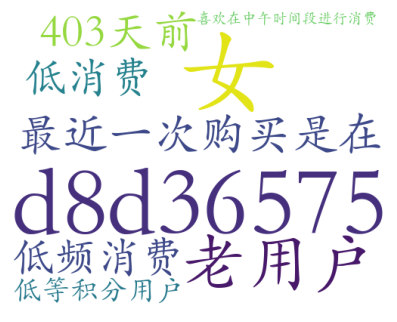

In [68]:
wc_plot(df_profile, 'd8d36575')

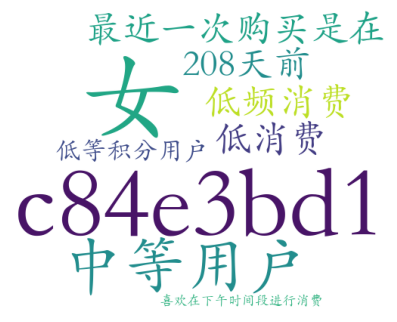

In [69]:
# 随机一个用户绘制 词云
wc_plot(df_profile)

## 5 会员用户细分和营销方案指定
### 5.1 会员用户的聚类分析和可视化

[standardScaler中数据预处理方法](https://blog.csdn.net/elvirangel/article/details/104516524)  
数据预处理方法：fit() transform() fit_transform()  
- fit():简单理解，就是求得训练集x的 **均值，方差，最大值，最小值** 这些训练集x固有的属性
- transform():在fit处理的基础上，进行**标准化，降维，归一化** 等操作（看具体使用的哪个工具，如PCA，StandardScaler等）。
- fit_transform():fit和transform的组合，既包括了训练又包括了转换

[标准化和归一化](https://blog.csdn.net/weixin_36604953/article/details/102652160)
- 标准化(Standardization):将数据变换为 **均值为0**， **标准差为1** 的分布。切记，<mark>不一定是正态分布。</mark>
- 归一化(Normalization):将一列数据变化到**某个固定区间（范围）中** ，通常，这个区间是[0,1],广义的讲，可以是各种区间。
- 中心化：零均值处理，将每个**原始数据减去这些数据的均值** 

[KMeans](https://zhuanlan.zhihu.com/p/208306755)  
[KMeans的使用](https://zhuanlan.zhihu.com/p/426622082)  
**k均值聚类算法（k-means clustering algorithm)** 是一种迭代求解的聚类分析算法， 将数据集中某些方面相似的数据进行**分组组织**的过程。  
聚类：发现这种内在结果的技术，而k均值是聚类算法中最著名的算法，**无监督学习**。将相似的数据尽可能聚集到一起，不同的数据尽可能分离。  
步骤：
1. 将数据集分为k组（k由用户指定）
2. 随机选择k个对象作为初始的聚类中心
3. 计算每个对象与各个聚类中心的距离，把每个对象分配给最近的聚类中心；聚类中心以及分配给他们的对象就代表一个聚类。
4. 每分配一个样板，聚类中心会根据聚类中现有的对象被重新计算。这个过程将不断重复直到满足某个终止条件

聚类条件可以分为两种：
1. 没有 或 设置的最小数目的对象被重新分配给不同的聚类
2. 没有 或 设置的最小数目的聚类中心再发生变化

[silhouette_score](https://blog.csdn.net/maple05/article/details/110454075)  
轮廓系数（Silhouette Coefficient),聚类效果好坏的一种评价方式。  
最佳值为1， 最坏为-1。接近0的值表示**重叠的群集**，负值通常表示样本已分配给错误的聚类，因为不同的聚类更为相似。  
这个函数的作用是**返回所有样本的平均轮廓系数**，要获取每个样本的轮廓系数，需要使用**silhouette_samples**

[MinMaxScaler](https://blog.csdn.net/GentleCP/article/details/109333753)  
归一化方法

In [70]:
# 对数据进行标准化处理 取出LRFMP对应的列
df0 = df.iloc[:, 1:6]
# StandardScaler类 是一个用来将数据进行 归一化和标准化 的类。计算训练集的平均值和标准差，以便测试数据集使用相同的变换
res_std = StandardScaler().fit_transform(df0)

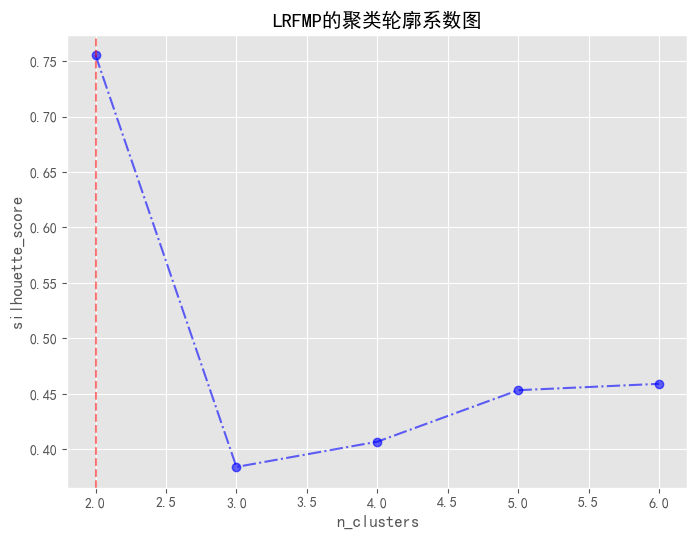

In [71]:
# 对数据进行聚类 KMeans
n_clusters = range(2, 7)
# 轮廓系数
scores = []
for i in range(len(n_clusters)):
    clf = KMeans(n_clusters = n_clusters[i], random_state = 20).fit(res_std)
    scores.append(silhouette_score(res_std, clf.labels_))
maxindex = scores.index(max(scores))
plt.figure(figsize = (8, 6), dpi = 100) 
plt.plot(n_clusters, scores, linestyle = '-.', c = 'b', alpha = 0.6, marker = 'o')
plt.axvline(x = n_clusters[maxindex], linestyle = '--', c = 'r', alpha = 0.5)
plt.title('LRFMP的聚类轮廓系数图')
plt.ylabel('silhouette_score')
plt.xlabel('n_clusters')
plt.savefig('./images/LRFMP聚类轮廓系数图.png')

In [72]:
# 构造一个绘制聚类可视化效果雷达图的函数
def plot(features, clf_list, nrow, ncol, title):
    """
    features: 字段名
    clf_list：list，为聚类器列表
    nrow: 图的行数
    ncol: 图的列数
    title: 图的名称
    """
    N = len(features)
    # linspace:指定间隔内，返回均匀分布的数值；N:返回的数量，默认50；endpoint：默认 True，包括stop；False：不包括stop
    angles = np.linspace(0, 2 * np.pi, N, endpoint = False)
    # 沿现有轴加入一系列数组
    angles = np.concatenate([angles, [angles[0]]])
    features = np.concatenate([features, [features[0]]])
    fig = plt.figure(figsize = (14, 14), dpi = 100)
    for i in range(len(clf_list)):
        clf = clf_list[i]
        centers = clf.cluster_centers_
        # add_subplot的index从1开始
        ax = fig.add_subplot(nrow, ncol, i + 1, polar = True)
        ax.set_thetagrids(angles * 180 / np.pi, features)
        # 随机取不同的颜色
        colors = np.random.choice(['r', 'g', 'b', 'y', 'k', 'orange'], replace = False, size = len(centers))
        for j in range(len(centers)):
            values = np.concatenate([centers[j, :], [centers[j, :][0]]])
            ax.plot(angles, values, c = colors[j], alpha = 0.6, linestyle = '-.', label = '类别' + str(j + 1))
            ax.fill(angles, values, c = colors[j], alpha = 0.2)
        ax.set_title(f'n_clusters = {len(centers)}')
        ax.legend()
    plt.suptitle(title)
    plt.savefig(f'./images/{title}.png')

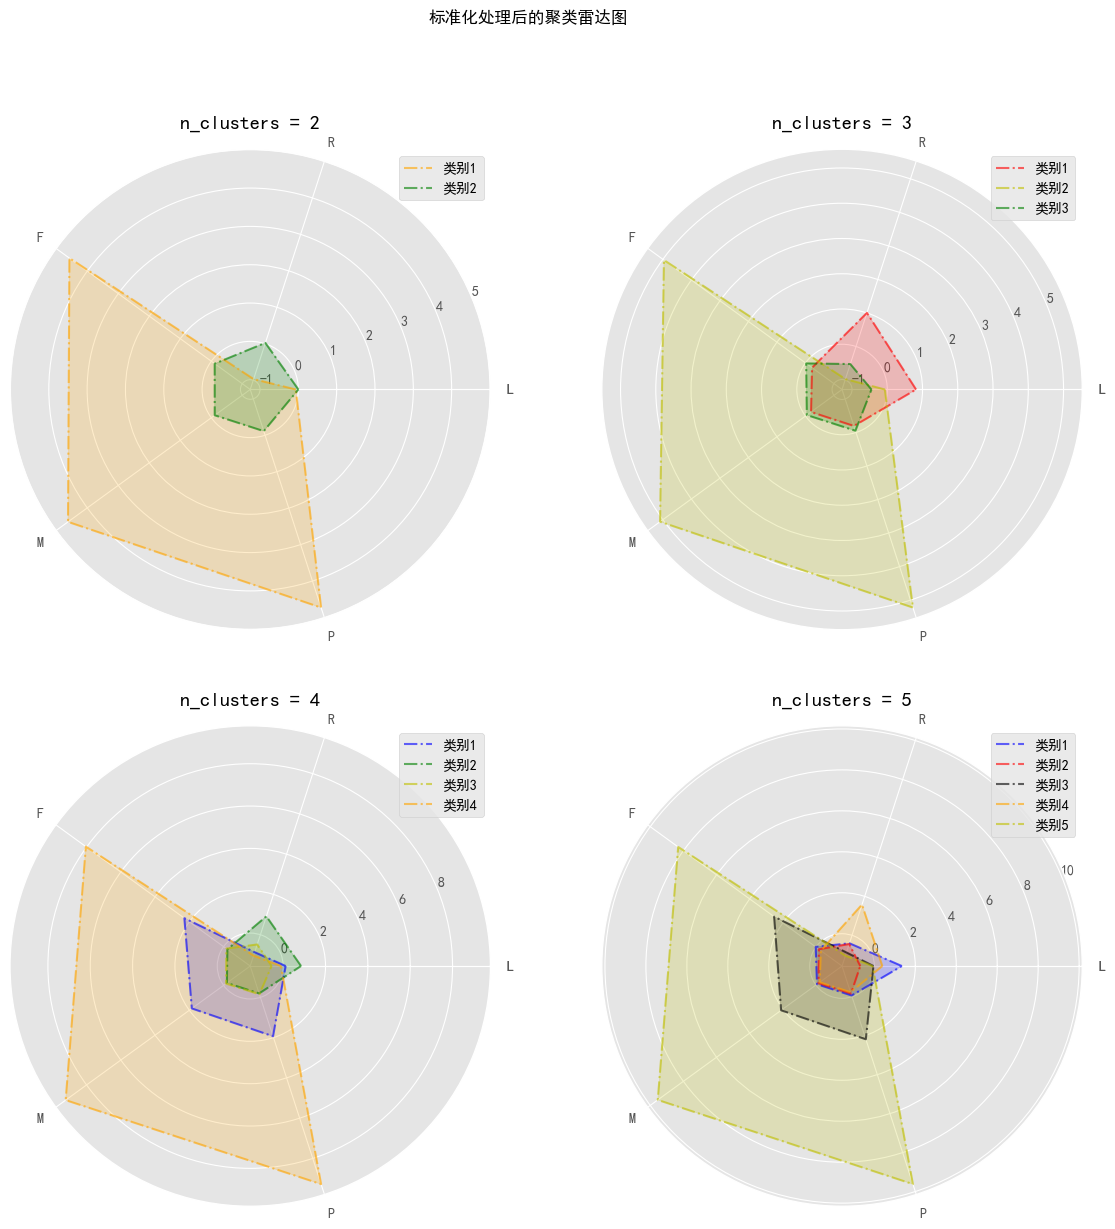

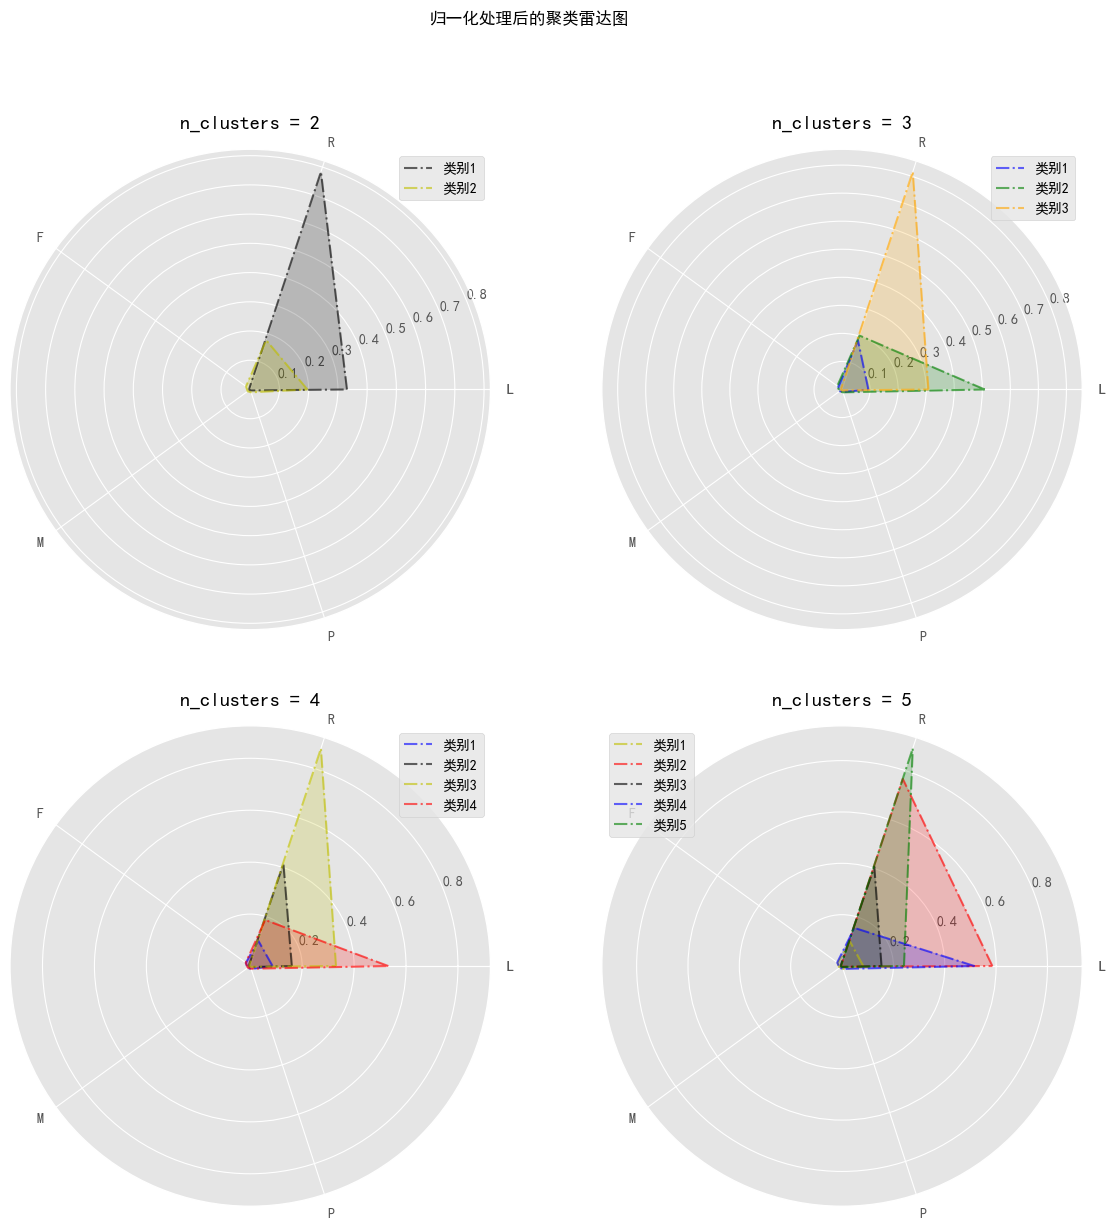

In [73]:
features = list('LRFMP')
res_std = StandardScaler().fit_transform(df0)
res_mm = MinMaxScaler().fit_transform(df0)
res = [res_std, res_mm]
titles = ['标准化处理后的聚类雷达图', '归一化处理后的聚类雷达图']
for i in range(len(res)):
    clf = []
    for j in range(2, 6):
        clf.append(KMeans(n_clusters = j, random_state = 20).fit(res[i]))
    plot(features, clf, 2, 2, titles[i])

上面的结果分析出，标准化后的数据聚类效果好于归一化处理的效果，且从轮廓系数和聚类雷达图也可以看出，聚类数最佳为2。因此，下面使用聚类数为2的标准化数据进行聚类，得到两类客户的LRFMP均值数据，以此来判断两者之间的差异

### 5.2 对会员用户进行精细化划分 并分析不同群体带来的价值差异

In [74]:
# 以聚类数位2贴上对应的标签
clf = KMeans(n_clusters = 2, random_state = 20).fit(res_std)
df0['labels'] = clf.labels_
df0

,L,R,F,M,P,labels
0,23.933333,13.433333,2,5266.5,5267.0,1
1,107.066667,2.066667,7,12850.0,11850.0,1
2,52.300000,0.566667,10,6340.8,6141.0,1
3,56.066667,2.266667,1,8964.0,8964.0,1
4,18.200000,2.066667,1,236.0,236.0,1
...,...,...,...,...,...,...
42543,9.333333,9.333333,1,300.0,300.0,1
42544,1.166667,1.166667,1,5530.0,5530.0,1
42545,57.433333,19.700000,2,7139.0,7139.0,1
42546,80.966667,11.600000,12,11712.0,11712.0,1


[f-string格式化输出](https://www.jianshu.com/p/f4f9c75d99a1)

In [75]:
# 统计两类用户之间的差异，发现两类客户之间数量相差过大
# 1 数量
label_L_num = df0['labels'].value_counts().values[0]
# 0 数量
label_O_num = df0['labels'].value_counts().values[1]
# 总数量
all_num = label_L_num + label_O_num
# 直接加f表示默认进度 6位小数
print(f'类别0所占比列为：{label_O_num / all_num:f}\t 类别1所占比列为：{label_L_num / all_num:f}')
df0['labels'].value_counts()

类别0所占比列为：0.023362	 类别1所占比列为：0.976638


1    41554
0      994
Name: labels, dtype: int64

In [76]:
# 用均值来计算两类样板之间LRFMP
L_avg = df0.groupby('labels').agg({'L' : np.mean}).reset_index()
R_avg = df0.groupby('labels').agg({'R' : np.mean}).reset_index()
F_avg = df0.groupby('labels').agg({'F' : np.mean}).reset_index()
M_avg = df0.groupby('labels').agg({'M' : np.mean}).reset_index()
P_avg = df0.groupby('labels').agg({'P' : np.mean}).reset_index()

In [77]:
# 绘制相关的条形图
def plot_bar(df_list, nrow, ncol):
    fig, axs = plt.subplots(nrow, ncol, figsize = (2 * (ncol + 2), 2.5), dpi = 100)
    for i in range(len(axs)):
        ax = axs[i]
        df = df_list[i]
        ax.bar(df.iloc[:, 0], df.iloc[:, 1], color = 'm', alpha = 0.4, width = 0.5)
        for x, y in enumerate(df.iloc[:, 1].tolist()):
            ax.text(x, y / 2, '%.0f' % y, va = 'bottom', ha = 'center', fontsize = 12)
        ax.set_xticks([0, 1])
        ax.set_yticks(())
        ax.set_title(f'{df.columns[1]}')
    plt.suptitle('两类客户的LRFMP均值差异', y = 1.1, fontsize = 14)
    plt.savefig('./images/两类客户的LRFMP均值差异.png')

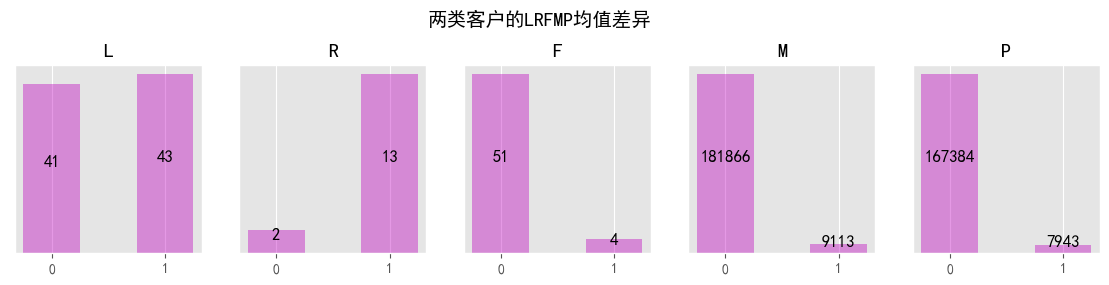

In [78]:
df_list = [L_avg, R_avg, F_avg, M_avg, P_avg]
plot_bar(df_list, 1, 5)

从上面的结果分析  
标签1的客户消费频次、消费金额、和消费积分均远大于标签0的客户，且这类客户所占的比列仅有2.3%，可以将其定义为“重要保持会员”。  
标签0的客户所占比列为97.7%，其会员登记时间跟标签1的比较接近，但最近一次消费时间较标签1的要长，可以将其定义为“一般发展会员”。

参考项目地址：https://www.heywhale.com/mw/project/61342a57c9c30f001878d043/content